<img style="float: left;" alt="Drawing" src="./figures/3Di_beeldmerk_RGB.png" width="100"/> </td>
<img style="float: right;" alt="Drawing" src="./figures/lizard-beeldmerk-donker-groen.jpg" width="80"/> </td>                                                                                                                            

## Using 3Di and Lizard together in one Jupyter notebook

Welcome! In this notebook we will show how our two IT products <a href="https://3diwatermanagement.com/">3Di</a> and <a href="https://lizard.net/">Lizard</a> can be used together for an operational 3Di model. The following steps will be taken according to an example of an 3Di model:
- **step 1:** Starting a 3Di simulation by using the threedi-api
- **step 2:** Using radar rainfall date from Lizard for the simulation
- **step 3:** Downloading the results of the 3Di-simulation

For this tutorial we make use of the "BWN-Schermer" 3Di-model:


<img style="float: left;" alt="Drawing" src="./figures/3di_model_bwn_schermer.PNG" width="700"/> 

**Step 1: Starting a 3Di simulation by using the threedi-api**

Importing all required packages:

In [1]:
from datetime import datetime
from getpass import getpass
import pandas as pd
import json
from threedi_api_client.threedi_api_client import ThreediApiClient
from threedi_api_client.api import ThreediApi
from threedi_api_client.versions import V3Api
from threedi_api_client.openapi import ApiException
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests
from pathlib import Path
from login import get_login_details
import numpy as np
import configparser
import os
from time import sleep

Provide credentials to connect to the threedi-api, for login the script login.py will be used. You can find the format in  for delivering your details in login_detail.ini. 

In [2]:
CONFIG = {
    "THREEDI_API_HOST": "https://api.3di.live",
    "THREEDI_API_USERNAME": get_login_details(option='username'),
    "THREEDI_API_PASSWORD": get_login_details(option='password')
}  #
THREEDI_API = ThreediApi(config=CONFIG, version='v3-beta')

Check the connection with the provided credentials:

In [3]:
try:
    user = THREEDI_API.auth_profile_list()
except ApiException as e:
    print("Oops, something went wrong. Maybe you made a typo?")
else:
    print(f"Successfully logged in as {user.username}!")

Successfully logged in as olof.baltus!


Let's find the model:

In [4]:
models = THREEDI_API.threedimodels_list(name__icontains='bwn_schermer_1d2d_glg')
my_model =models.results[0]
print(my_model.name)

bwn-schermer - bwn_schermer_1d2d_glg (5) #20


Let's see which organisations are available within my user account:

In [5]:
organisations = THREEDI_API.organisations_list(name__icontains='N&S')


for organisation in organisations.results:
    print(f"{organisation.name}: {organisation.unique_id}")

# In this example we use the organisation from N&S Demo:
organisation_uuid = "61f5a464c35044c19bc7d4b42d7f58cb"

N&S Branch Office: 74983d5a0fd84c22bb09e7656d570fb6
N&S Demo: a1993f6e13564e9687ae03a3604463f9


The next step is to create a simulation. Note that it will not run yet.

In [6]:
my_simulation = THREEDI_API.simulations_create(
    data={
        "name": "demo_3di_lizard_notebook_schermer",
        "threedimodel": my_model.id,
        "organisation": organisation_uuid,
        "start_datetime": datetime(2020, 11, 15, 14, 00),
        "duration": 3600  # in seconds, so we simulate for 1 hour
    }
)


#print an overview of the simulation
my_simulation

{'cloned_from': None,
 'compute_cluster': None,
 'created': 'now',
 'duration': 3600,
 'duration_humanized': '1 hours, 0 minutes, 0 seconds',
 'end_datetime': datetime.datetime(2020, 11, 15, 15, 0, tzinfo=tzutc()),
 'id': 97755,
 'name': 'demo_3di_lizard_notebook_schermer',
 'organisation': '61f5a464c35044c19bc7d4b42d7f58cb',
 'organisation_name': 'Nelen & Schuurmans Consultancy',
 'slug': 'demo_3di_lizard_notebook_schermer-74179925-c27e-4ebb-aaca-4320744f5b28',
 'start_datetime': datetime.datetime(2020, 11, 15, 14, 0, tzinfo=tzutc()),
 'tags': [],
 'threedicore_version': None,
 'threedimodel': 'https://api.3di.live/v3/threedimodels/51041/',
 'threedimodel_id': 51041,
 'url': 'https://api.3di.live/v3/simulations/97755/',
 'user': 'olof.baltus',
 'uuid': '74179925-c27e-4ebb-aaca-4320744f5b28'}

In [7]:
#check the status of the simulation with:
status = THREEDI_API.simulations_status_list(my_simulation.id)
print(status)

{'created': datetime.datetime(2022, 10, 14, 14, 14, 47, 750704, tzinfo=tzutc()),
 'exit_code': None,
 'id': 456055,
 'name': 'created',
 'paused': None,
 'time': 0.0}


We can see the simulation has not started yet. The options at the name of the status can be: "created", "started" and "finished".

**Step 2: Using radar rainfall data from Lizard for the simulation**

In previous step we created a simulation for the 3di model of v2_BWN Schermer. In this step we will add a rain event to the simulation and start the simulation. The rain event is extracted from the radar rainfall data within Lizard. We choose to simulate this specific date and time (15-11-2020 14:00 PM) and then extract the rainfall for 1 hour (until 15:00 PM). The simulation is also defined for 1 hour, which means the simulation stops immediately after the added rainfall event.

<table><tr>
<td> <img alt="Drawing" src="./figures/radar_rainfall_lizard.PNG" width="4000"/> </td>
</tr></table>


For the rain we have to define the starttime, endtime and duration of the chosen rainfall event and the uuid of the rainfall raster within Lizard:

In [8]:
#define start- and endtime of the radar rainfall data
start = datetime(2020, 11, 15, 14, 00)
end = start + timedelta(hours=1) #1 hour rainfall simulation
duration = end - start
print ("Starttime of the radar rainfall event:", start)
print ("Endtime of the radar rainfall event:", end)
print ("Duration of the radar rainfall event in seconds:", duration.total_seconds(), "seconds")

uuid = "730d6675-35dd-4a35-aa9b-bfb8155f9ca7"
print ("Raster rainfall uuid of Lizard:", uuid)

Starttime of the radar rainfall event: 2020-11-15 14:00:00
Endtime of the radar rainfall event: 2020-11-15 15:00:00
Duration of the radar rainfall event in seconds: 3600.0 seconds
Raster rainfall uuid of Lizard: 730d6675-35dd-4a35-aa9b-bfb8155f9ca7


Next step is to add this event to the created simulation in step 1:

In [9]:
#Upload radar rainfall from Lizard and wait for it to be processed
THREEDI_API.simulations_events_rain_rasters_lizard_create(
            my_simulation.id,
            data={
                "offset": 0,
                "duration": int(duration.total_seconds()),
                "reference_uuid": uuid,
                "start_datetime": start,
                "units": "mm/h",
            },
        )

{'duration': 3600,
 'id': 51459,
 'interval': 300,
 'multiplier': 1.0,
 'offset': 0,
 'origin_offset': 0,
 'reference_uuid': '730d6675-35dd-4a35-aa9b-bfb8155f9ca7',
 'simulation': 'https://api.3di.live/v3/simulations/97755/',
 'start_datetime': datetime.datetime(2020, 11, 15, 14, 0, tzinfo=tzutc()),
 'store_path': 'rain',
 'uid': '63b3622c-795e-43ca-b679-eaf89dbe9749',
 'units': 'mm/h',
 'url': 'https://api.3di.live/v3/simulations/97755/events/rain/rasters/lizard/51459/',
 'user': 'olof.baltus'}

Let's print an overview of the added events to our simulation and check if the "lizardrasterrain" is not empty:

In [10]:
events = THREEDI_API.simulations_events(my_simulation.id)
print(events.lizardrasterrain)

[{'duration': 3600,
 'id': 51459,
 'interval': 300,
 'multiplier': 1.0,
 'offset': 0,
 'origin_offset': 0,
 'reference_uuid': '730d6675-35dd-4a35-aa9b-bfb8155f9ca7',
 'simulation': 'https://api.3di.live/v3/simulations/97755/',
 'start_datetime': datetime.datetime(2020, 11, 15, 14, 0, tzinfo=tzutc()),
 'store_path': 'rain',
 'uid': '63b3622c-795e-43ca-b679-eaf89dbe9749',
 'units': 'mm/h',
 'url': 'https://api.3di.live/v3/simulations/97755/events/rain/rasters/lizard/51459/',
 'user': 'olof.baltus'}]


Now a simulation has to be created from a simulation template: 

In [11]:
my_simulation_template = THREEDI_API.simulation_templates_list(simulation__threedimodel__id=my_model.id).results[0]
my_simulation = THREEDI_API.simulations_from_template(
        data={
            "template": my_simulation_template.id,
            "name": "demo_simulation_3dinotebook_schermer",
            "tags": ["demo_notebook_1"],
            "organisation": organisation_uuid,
            "start_datetime": datetime.now(),
            "duration": 3600 # in seconds, so we simulate for 1 hour
        }
    )

If you want to use post processing via Lizard, you can add this to your simulation:

In [12]:
# add lizard postprocessing
THREEDI_API.simulations_results_post_processing_lizard_basic_create(
    simulation_pk=my_simulation.id,
    data={
        "scenario_name": my_simulation.name,
        "process_basic_results": True,
    }
)

{'process_basic_results': True,
 'result_uuid': 'eb5a52c0-796b-4704-9af3-b1063bbc0513',
 'scenario_name': 'demo_simulation_3dinotebook_schermer',
 'simulation': 'https://api.3di.live/v3/simulations/97756/'}

In [13]:
THREEDI_API.simulations_actions_create(my_simulation.id, data={"name": "start"})

print(f"Started simulation {my_simulation.name} with model {my_model.name}")

Started simulation demo_simulation_3dinotebook_schermer with model bwn-schermer - bwn_schermer_1d2d_glg (5) #20


And check the status of the simulation with:

In [14]:
#check the status of the simulation with:
status = THREEDI_API.simulations_status_list(my_simulation.id)
print(status)

{'created': datetime.datetime(2022, 10, 14, 14, 16, 58, 388132, tzinfo=tzutc()),
 'exit_code': None,
 'id': 456057,
 'name': 'starting',
 'paused': None,
 'time': 0.0}


**Step 3: Downloading the results of the 3Di-simulation**

When our simulation has finished, it is time to analyse the results of the 3Di-model and validate the model with measurements from Lizard. Before that, we have to download all the results of the simulation. In this notebook we have already performed a 3Di simulation (with simulation id 14641), so let's select this simulation:

In [15]:
my_simulation = THREEDI_API.simulations_list(
    name=my_simulation.name, user__username=get_login_details(option='username')).results[0]

my_simulation

{'cloned_from': 'https://api.3di.live/v3/simulations/94125/',
 'compute_cluster': None,
 'created': '3 minutes ago',
 'duration': 3600,
 'duration_humanized': '1 hours, 0 minutes, 0 seconds',
 'end_datetime': datetime.datetime(2022, 10, 14, 17, 17, 14, tzinfo=tzutc()),
 'id': 97756,
 'name': 'demo_simulation_3dinotebook_schermer',
 'organisation': '61f5a464c35044c19bc7d4b42d7f58cb',
 'organisation_name': 'Nelen & Schuurmans Consultancy',
 'slug': 'demo_simulation_3dinotebook_schermer-2e747077-9ca7-415e-b160-6a8c50d8eeba',
 'start_datetime': datetime.datetime(2022, 10, 14, 16, 17, 14, tzinfo=tzutc()),
 'tags': ['demo_notebook_1'],
 'threedicore_version': None,
 'threedimodel': 'https://api.3di.live/v3/threedimodels/51041/',
 'threedimodel_id': 51041,
 'url': 'https://api.3di.live/v3/simulations/97756/',
 'user': 'olof.baltus',
 'uuid': '2e747077-9ca7-415e-b160-6a8c50d8eeba'}

When our simulation has finished, it is time to analyse the results of the 3Di-model and validate the model with measurements from Lizard. Before that, we have to download all the results of the simulation:

Let's see which result files are available and download all the results of the simulation model in a local folder:

In [16]:
result_files = THREEDI_API.simulations_results_files_list(my_simulation.id)  #fill in the id of your simulation as above

for result in result_files.results:
    print(result)

{'created': datetime.datetime(2022, 10, 14, 14, 19, 55, 767764, tzinfo=tzutc()),
 'description': '3Di results NetCDF4 file',
 'file': {'etag': 'b51a8fcf35ff290d3b7ef69f64dde2f4',
          'expiry_date': datetime.date(2022, 10, 22),
          'filename': 'results_3di.nc',
          'id': 498482,
          'meta': None,
          'size': 5355892,
          'state': 'uploaded',
          'state_description': 'File has been uploaded successfully',
          'type': 'results',
          'url': 'https://api.3di.live/v3/files/498482/'},
 'filename': 'results_3di.nc',
 'id': 201366,
 'simulation': 'https://api.3di.live/v3/simulations/97756/',
 'url': 'https://api.3di.live/v3/simulations/97756/results/files/201366/'}
{'created': datetime.datetime(2022, 10, 14, 14, 19, 55, 678008, tzinfo=tzutc()),
 'description': 'log files '
                'flow_summary,water_balance,timestep_reduction,iteration,simulation,matrix,core3di,core3dilog_data',
 'file': {'etag': 'fbe4ade032148b9d0657afad93f79ab9',


In [17]:
download_folder = Path(f'Results {my_simulation.name}')
download_folder.mkdir(exist_ok=True)

for file in result_files.results:
    download_url = THREEDI_API.simulations_results_files_download(
        id=file.id, simulation_pk=my_simulation.id
    )

    file_path = download_folder / file.filename
    r = requests.get(download_url.get_url)
    with open(file_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"Finished downloading {file.filename}")

Finished downloading results_3di.nc
Finished downloading log_files_sim_97756.zip


In addition to the results of the 3Di-simulation, we also have to download the "gridadmin.h5" file of the simulation. This is a model specific file so it's under the threedimodels-api. We'll also download this file:

In [18]:
download_url = THREEDI_API.threedimodels_gridadmin_download(my_model.id)

file_path = download_folder / "gridadmin.h5"
r = requests.get(download_url.get_url)
with open(file_path, "wb") as f:
    for chunk in r.iter_content(chunk_size=8192):
        f.write(chunk)

print(f"Finished downloading gridadmin.h5")

Finished downloading gridadmin.h5


All the files are now on a local folder and we can go to the next step of validation.

**Analysing the results and validate with measurements from Lizard**

In [19]:
#Import libraries
from threedigrid.admin.gridresultadmin import GridH5ResultAdmin
from threedigrid.admin.gridadmin import GridH5Admin
import os

In [20]:
#Define paths and files
result_path = download_folder
nc = os.path.join(result_path,'results_3di.nc')
f = os.path.join(result_path,'gridadmin.h5')

#Load files into gr object
ga = GridH5Admin(f)
gr = GridH5ResultAdmin(f,nc)

Let's make a plot of the pumps within this 3Di-model:

Text(0.5, 1.0, 'Overview of the location of the pumps')

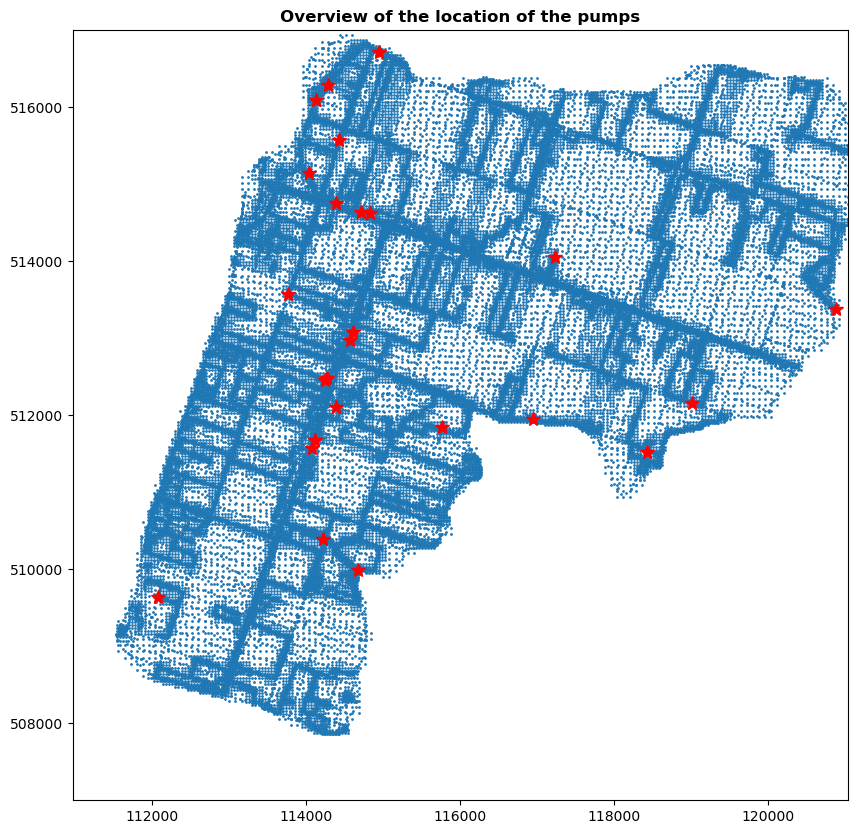

In [21]:
# Show in a plot where these nodes are in the model
plt.figure(figsize=(10,10))
plt.plot(ga.nodes.coordinates[0], ga.nodes.coordinates[1], '.', markersize=2)
plt.plot(ga.pumps.node_coordinates[0], ga.pumps.node_coordinates[1], '*', color='red', markersize=10)

plt.axis('tight')
plt.axis('equal')

plt.xlim(112000, 120000)
plt.ylim(507000, 517000)

plt.title('Overview of the location of the pumps', fontweight='bold')

Let's see the names of all pumps:

In [22]:
ga.pumps.display_name

array([b'', b'VOPO', b'Poldermolen D', b'LEEG', b'LEEG', b'LEEG', b'LEEG',
       b'LEEG', b'VOPO', b'LEEG', b'LEEG', b'LEEG', b'LEEG', b'LEEG',
       b'LEEG', b'VOPO', b'Willem Alexander', b'LEEG', b'LEEG', b'VOPO',
       b'LEEG', b'LEEG', b'Beatrix', b'LEEG', b'LEEG', b'Maatregelpomp'],
      dtype='|S64')

And select the pump Beatrix:

In [23]:
x_beatrix = ga.pumps.node_coordinates[0][-4]
y_beatrix = ga.pumps.node_coordinates[1][-4]

Text(0.5, 1.0, 'Location of Beatrix pumping station')

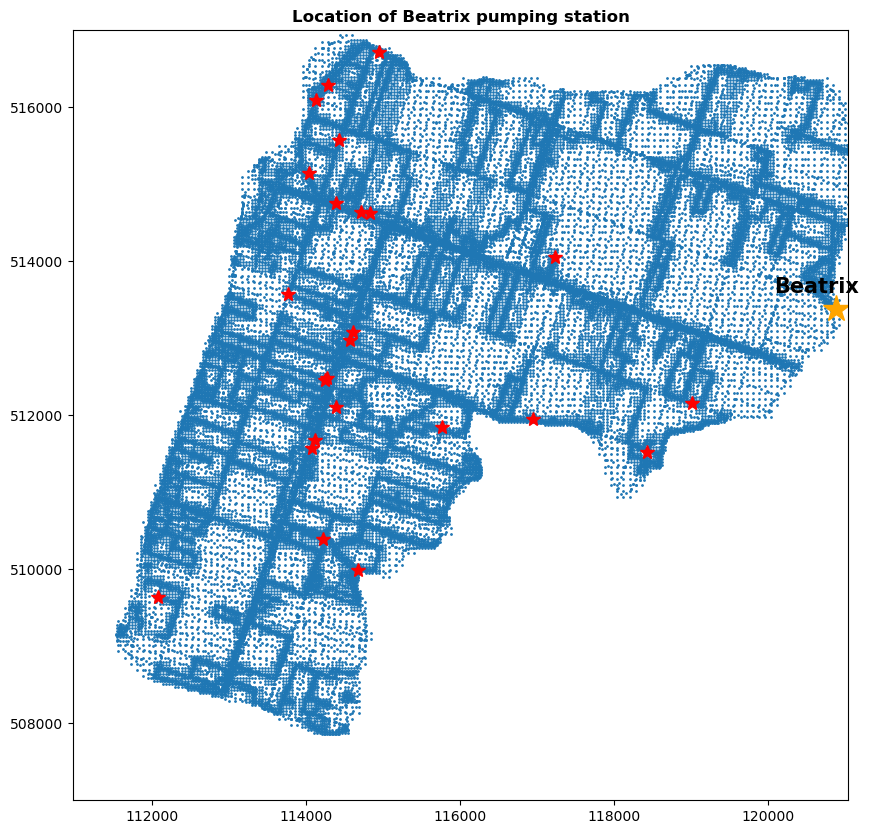

In [24]:
# Show in a plot where these nodes are in the model
plt.figure(figsize=(10,10))
plt.plot(ga.nodes.coordinates[0], ga.nodes.coordinates[1], '.', markersize=2)
plt.plot(ga.pumps.node_coordinates[0], ga.pumps.node_coordinates[1], '*', color='red', markersize=10)
plt.plot(x_beatrix, y_beatrix, '*', color='orange', markersize=20)
plt.text(x_beatrix-800, y_beatrix+200, 'Beatrix', fontsize=15, fontweight='bold')

plt.axis('tight')
plt.axis('equal')

plt.xlim(112000, 120000)
plt.ylim(507000, 517000)

plt.title('Location of Beatrix pumping station', fontweight='bold')

In [25]:
#connection node of this pumping station
print (gr.pumps.display_name)
pump_beatrix_connectionnode=gr.pumps.node1_id[-4]
#Select timeseries of pumping station Beatrix
pump_beatrix = gr.pumps.filter(display_name__in='Beatrix').timeseries(start_time=0,end_time=3600)

[b'' b'VOPO' b'Poldermolen D' b'LEEG' b'LEEG' b'LEEG' b'LEEG' b'LEEG'
 b'VOPO' b'LEEG' b'LEEG' b'LEEG' b'LEEG' b'LEEG' b'LEEG' b'VOPO'
 b'Willem Alexander' b'LEEG' b'LEEG' b'VOPO' b'LEEG' b'LEEG' b'Beatrix'
 b'LEEG' b'LEEG' b'Maatregelpomp']


In [26]:
pump_beatrix.node1_id

array([38305])

In [33]:
#filter results for a connection node
model_ts = gr.lines.subset("2D_OPEN_WATER").timeseries(start_time=0, end_time=3600).data["timestamps"]
model_wl = gr.nodes.filter(id__in=[38305]).timeseries(start_time=0, end_time=3600).s1

Text(0.5, 1.0, 'Waterlevel at the Beatrix Pump - BWN Schermer')

<Figure size 640x480 with 0 Axes>

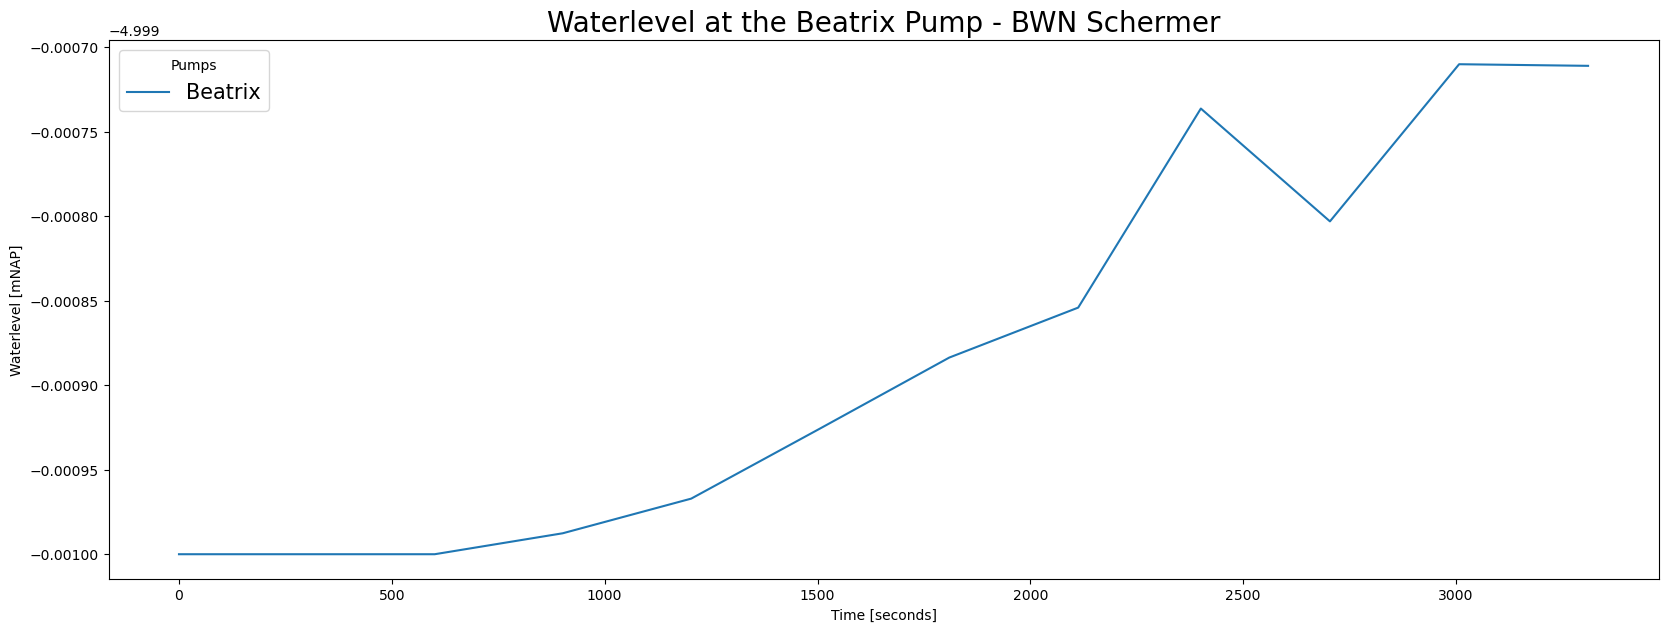

In [38]:
plt.figure()

# If you want to change the size and shape of only this figure
plt.figure(figsize=(20,7))

# Plotting the timeseries of your selection
plt.plot(model_ts,model_wl)

# Defining the legend based on the nodes of your selection
plt.legend(['Beatrix'], frameon=True, fontsize=15, title='Pumps')

# Naming your axis
plt.xlabel('Time [seconds]')
plt.ylabel('Waterlevel [mNAP]')

# Title of your Figure
plt.title('Waterlevel at the Beatrix Pump - BWN Schermer', fontsize=20)


**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**
The end

In this tutorial we showed you how 3Di and Lizard can be used together, by taking the following steps into account:
- how to start a simulation of a 3Di-model, 
- how to radar rainfall data from Lizard to your simulation, 
- how to download the results of the model simulation,
- and in the end how to visualise your model results. 

This is all possible within a Jupyter notebook by making use of the API-v3 (3Di) and the REST-API from Lizard . Ofcourse there are a lot more options for the analysis (validation) possible. Or for the events you can add to your simulation. 

Do you want to learn more or are you interested in some more possible analysis in a jupyter notebook? 

**Please contact**:

Olof Baltus | olof.baltus@nelen-schuurmans.nl

Jonas van Schrojenstein | jonas.vanschrojenstein@nelen-schuurmans.nl
